## Урок 5. Кейс 1. Аномалии и артефакты

In [365]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [366]:
def test_ts_stationarity(ts):
    ma = ts.rolling(12).mean()
    std = ts.rolling(12).std()
    plt.figure(figsize=(12, 10))
    orig = plt.plot(ts, color='blue', label='Original')
    mean = plt.plot(ma, color='red', label='Rolling mean')
    std = plt.plot(std, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title("Rolling mean & std")
    plt.show()
    #adf test
    print("Results of DF test:")
    dftest = adfuller(ts, autolag='AIC')
    df_test = pd.DataFrame(dftest[:-1])
    df_test.index = ['Test statistic', 'p_value', 'lags', 'num observations', 'critical values']
    print(df_test)

In [367]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Дата') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Дата') >  split_date].copy()

In [368]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [369]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
#### 2. Добавьте первые разности по стоимости доллара и евро к рублю (можно добавить и сами курсы валют - прошлые значения)
#### 3. Сделайте ее перерасчет (ресемплинг) в представление по неделям.

Получим данные по brent

In [370]:
brent = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
brent.sort_index(inplace=True)
brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Text(0, 0.5, 'USD')

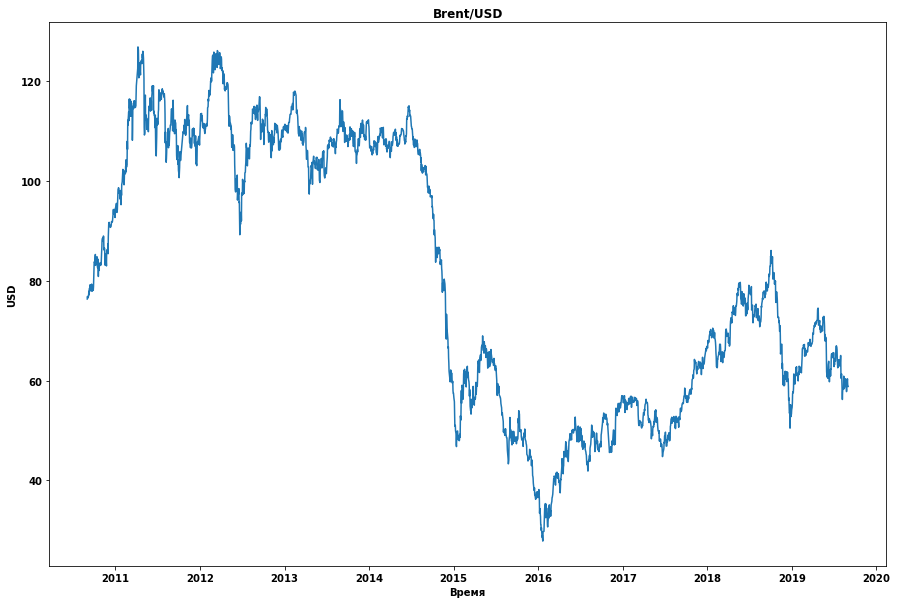

In [371]:
plt.figure(figsize=(15, 10))
plt.plot(brent['Значение'])
plt.title('Brent/USD')
plt.xlabel('Время')
plt.ylabel('USD')

Получим данные по USD

In [372]:
usd = pd.read_excel('USD_01_09_2010_01_09_2019.xlsx', index_col=[1], parse_dates=[1])
usd.drop(['nominal','cdx'], axis=1, inplace=True)
usd.head()

,curs
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


Text(0, 0.5, 'Руб')

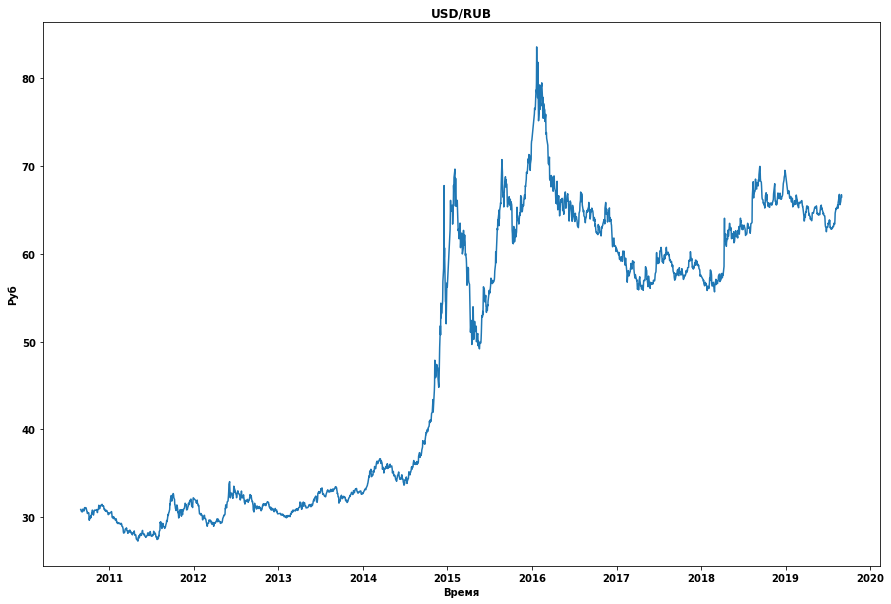

In [373]:
plt.figure(figsize=(15, 10))
plt.plot(usd['curs'])
plt.title('USD/RUB')
plt.xlabel('Время')
plt.ylabel('Руб')

Получим данные по EUR

In [374]:
eur = pd.read_excel('EUR_01_09_2010_01_09_2019.xlsx', index_col=[1], parse_dates=[1])
eur.drop(['nominal','cdx'], axis=1, inplace=True)
eur.head()

,curs
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


Text(0, 0.5, 'Руб')

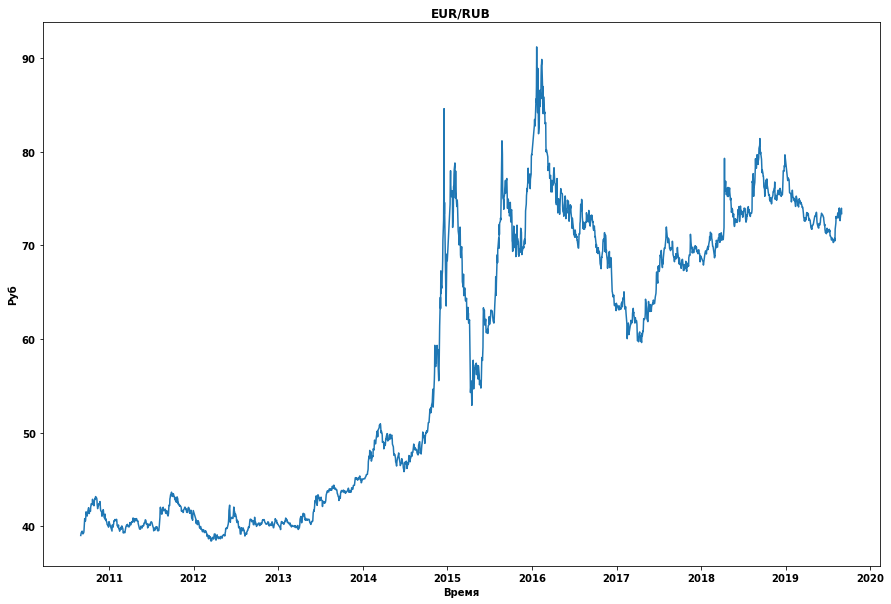

In [375]:
plt.figure(figsize=(15, 10))
plt.plot(eur['curs'])
plt.title('EUR/RUB')
plt.xlabel('Время')
plt.ylabel('Руб')

Соединим brent, usd, eur вместе

In [376]:
data = brent.\
        join(pd.DataFrame(usd), how="left").rename(columns={'curs': 'usd_curs'}).\
        join(pd.DataFrame(eur), how="left").rename(columns={'curs': 'eur_curs'}).\
        fillna(method='ffill')
data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd_curs,eur_curs
Дата,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,30.8669,39.0127
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,30.8001,39.1654
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,30.6858,39.2901
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,30.6922,39.3505
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,30.6922,39.3505


Сделаем ресемплинг по неделям с удалением ненужных полей

In [377]:
w_data = data.drop(columns=['dayofmonth', 'dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday']).\
    resample('W').mean()
w_data.head()

,Значение,year,month,quarter,weekofyear,usd_curs,eur_curs
Дата,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,30.747440,39.233840
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,30.777050,39.302883
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,30.844500,39.764250
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,31.012233,40.967983
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,30.607417,41.345817


Получим первые разности по brent

Text(0, 0.5, 'USD')

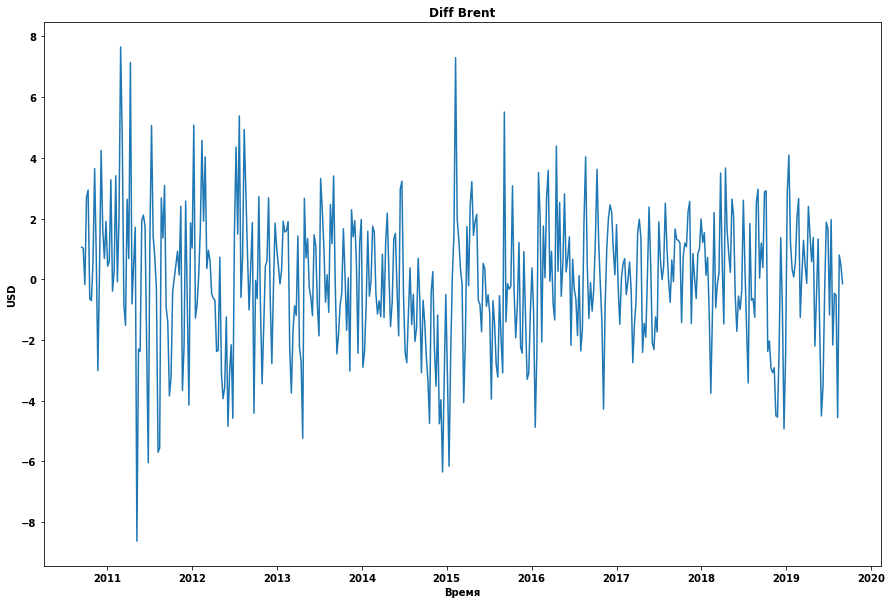

In [378]:
brent_diff = w_data['Значение'].diff().dropna()

plt.figure(figsize=(15, 10))
plt.plot(brent_diff)
plt.title('Diff Brent')
plt.xlabel('Время')
plt.ylabel('USD')

Получим первые разности для USD и EUR

In [379]:
usd_diff = w_data['usd_curs'].diff().dropna()
eur_diff = w_data['eur_curs'].diff().dropna()

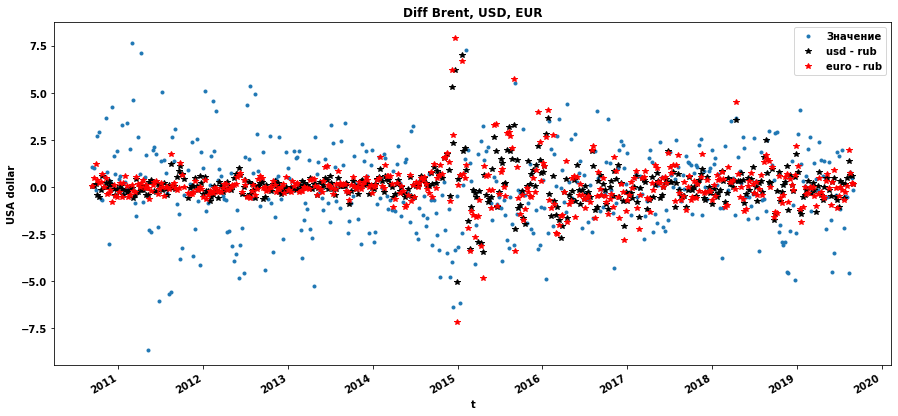

In [380]:
brent_diff.plot(style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(usd_diff.index, usd_diff, '*k', label='usd - rub')
plt.plot(eur_diff.index, eur_diff, '*r', label='euro - rub')
plt.title('Diff Brent, USD, EUR')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Присоединим данные по разностям к основной таблице

In [381]:
w_data = w_data.\
        join(pd.DataFrame(brent_diff), how="left", rsuffix='_diff').\
        join(pd.DataFrame(usd_diff), how="left", rsuffix='_diff').\
        join(pd.DataFrame(eur_diff), how="left", rsuffix='_diff').\
        fillna(method='ffill').drop(w_data.index[0])
w_data.head()

,Значение,year,month,quarter,weekofyear,usd_curs,eur_curs,Значение_diff,usd_curs_diff,eur_curs_diff
Дата,,,,,,,,,,
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,30.777050,39.302883,1.057333,0.029610,0.069043
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,30.844500,39.764250,1.020000,0.067450,0.461367
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,31.012233,40.967983,-0.175000,0.167733,1.203733
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,30.607417,41.345817,2.693333,-0.404817,0.377833
2010-10-10,84.146667,2010.0,10.000000,4.000000,40.0,30.100717,41.540667,2.935000,-0.506700,0.194850


Найдём аномалии

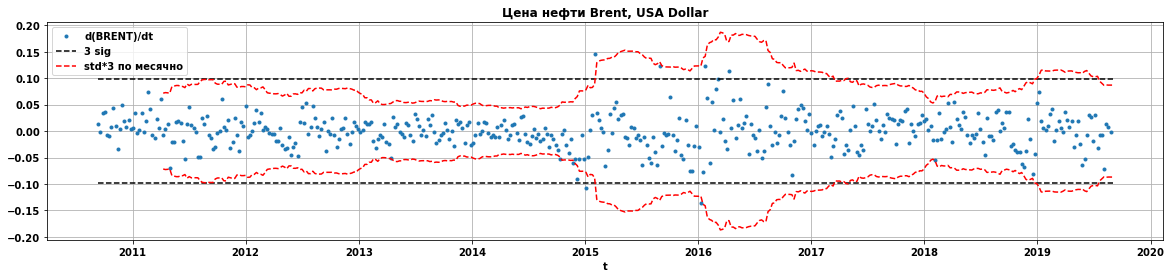

In [382]:
d_brent_data1 = (w_data['Значение'].values[1:] - w_data['Значение'].values[:-1]) / w_data['Значение'].values[:-1]
std_d_brent = pd.DataFrame(data=d_brent_data1, index=w_data.index[1:]).rolling(30).std()
s_brent1 = np.std(d_brent_data1)*3 
plt.figure(figsize=(20,4))
plt.plot(w_data.iloc[:-1].index, d_brent_data1, '.', label='d(BRENT)/dt')
plt.plot(w_data.iloc[[0,-1]].index, [s_brent1, s_brent1], '--k', label='3 sig')
plt.plot(w_data.iloc[[0,-1]].index, [-s_brent1, -s_brent1], '--k')
plt.plot(std_d_brent.index, std_d_brent*3, '--r', label='std*3 по месячно')
plt.plot(std_d_brent.index, -std_d_brent*3, '--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

In [383]:
# Нашли 3 точки
anomal_ind_0 = abs(d_brent_data1)>std_d_brent.values[:,0]*3
anomal_ind = np.hstack(([False], anomal_ind_0))
anomal = w_data[anomal_ind]
anomal

C:\Users\rseme\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


,Значение,year,month,quarter,weekofyear,usd_curs,eur_curs,Значение_diff,usd_curs_diff,eur_curs_diff
Дата,,,,,,,,,,
2014-12-14,64.065000,2014.0,12.0,4.0,50.0,54.012483,66.822883,-6.346667,2.344817,2.779683
2015-01-11,50.908333,2015.0,1.0,1.0,2.0,56.258400,68.342700,-6.159667,0.644160,0.661740
2015-02-08,57.316667,2015.0,2.0,1.0,6.0,68.139433,77.349800,7.296667,0.902733,1.178333


In [384]:
# Удалим их
w_data.drop(anomal.index, inplace=True)

#### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

Масштабирование

In [385]:
p = 0
h = 1

scl_target_1 = StandardScaler() 
target_1 = w_data['Значение'].values[h+p:].reshape((w_data.shape[0]-h-p,1))
y = scl_target_1.fit_transform(target_1)
y.shape

(465, 1)

In [386]:
scl_x_1 = StandardScaler() 
X = w_data.iloc[p:-h,:].values
X = scl_x_1.fit_transform(X.astype('float64'))
X.shape

(465, 10)

Разделение данных на тестовые и тренировочные

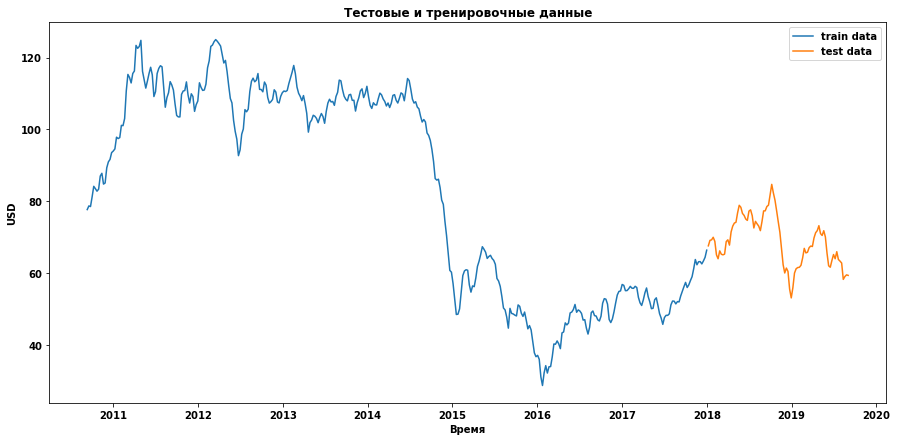

In [387]:
train_1, test_1 = split_data(w_data, '01-06-2018')
X_train_1 = X[:train_1.shape[0],:]
y_train_1 = y[:train_1.shape[0],0]
X_test_1 = X[train_1.shape[0]:,:]
y_test_1 = y[train_1.shape[0]:,0]

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('USD')
plt.plot(train_1.index.get_level_values('Дата'),train_1['Значение'], label='train data')
plt.plot(test_1.index.get_level_values('Дата'),test_1['Значение'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

In [388]:
# Подбираем параметры
param_dist = {"max_depth": [1,2,3,4,5], 
              "n_estimators": [50,100,200,300,400,500]}
model_gr = GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, cv=5, random_state=0)
random_search.fit(X_train_1, y_train_1)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.785 (std: 0.222)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.766 (std: 0.148)
Parameters: {'n_estimators': 300, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.766 (std: 0.160)
Parameters: {'n_estimators': 50, 'max_depth': 5}



C:\Users\rseme\.conda\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [389]:
# Итоговая модель
model_g_1 = GradientBoostingRegressor(max_depth=1, n_estimators=200, random_state=0)
model_g_1.fit(X_train_1, y_train_1)
y_test_pred_g = model_g_1.predict(X_test_1)

er_g = mean_absolute_percentage_error(y_true=scl_target_1.inverse_transform(y_test_1),
                                      y_pred=scl_target_1.inverse_transform(y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.105882951306518 %


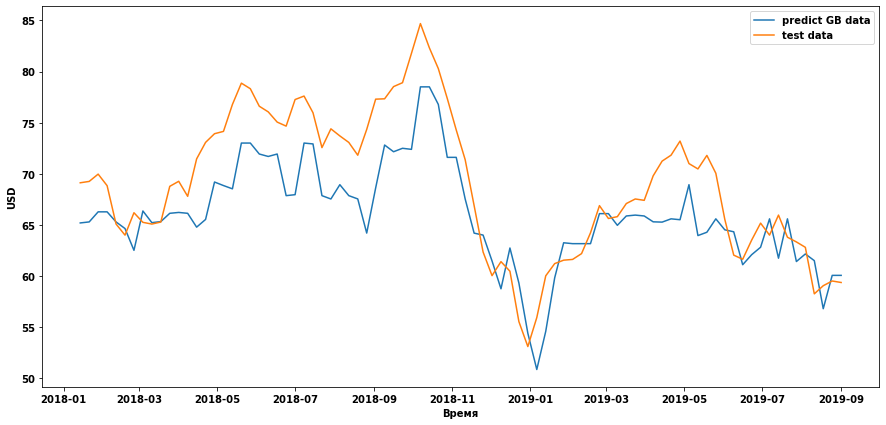

In [390]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('USD')
plt.plot(test_1.index[h+p:], scl_target_1.inverse_transform(y_test_pred_g), label='predict GB data' )
plt.plot(test_1.index[h+p:], scl_target_1.inverse_transform(y_test_1), label='test data')
plt.legend()
plt.show()

#### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

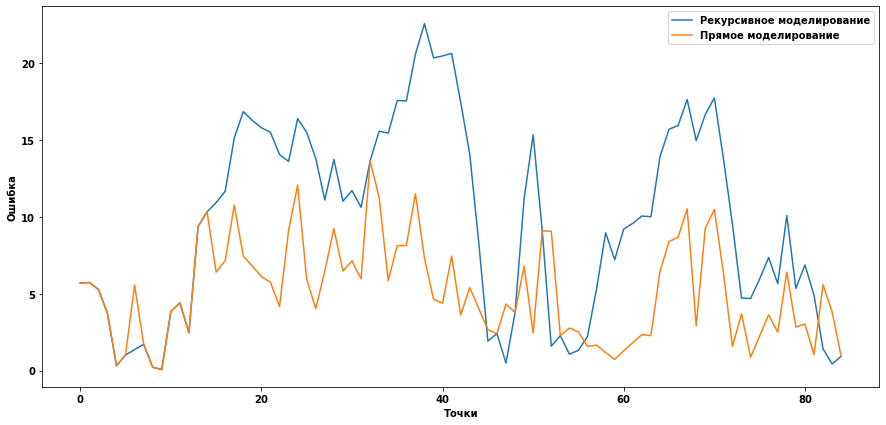

In [396]:
X_test_100 = np.array([X_test_1[0]])
y_test_100 = y_test_1[0]
N = len(y_test_1) - 1
err_recurs = []
err_direct = []

for i in range(N):
    # Рекурсивное моделирование
    # По последней известной строке предсказываем следующую и добавляем результат в y_test_100
    y_test_100 = np.hstack([y_test_100, model_g_1.predict(X_test_100[-1,:].reshape((1,10)))])
    # Вычисленное значение таргета надо сначало восстановить из масштабирования по таргету и затем отмасштабировать по X
    real_target = scl_target_1.inverse_transform([y_test_100[-1]])
    scl_target = scl_x_1.transform([np.concatenate((real_target, [0]*9), axis=0)])[0][0]
    # Заполняем вектор для прогноза следующей точки
    X_test_100 = np.vstack([X_test_100, X_test_1[i+1]])
    # Новое значение brent
    X_test_100[-1, 0] = scl_target
    # Ошибка
    err_recurs.append(mean_absolute_percentage_error(y_true=scl_target_1.inverse_transform([y_test_1[i]]),
                                                     y_pred=real_target))
    
    # Прямой прогноз
    y_test_pred_g = model_g_1.predict(X_test_1[i,:].reshape((1,10)))
    err_direct.append(mean_absolute_percentage_error(y_true=scl_target_1.inverse_transform([y_test_1[i]]),
                                                     y_pred=scl_target_1.inverse_transform(y_test_pred_g)))

# Нарисуем график ошибок
plt.figure(figsize=(15,7))
plt.xlabel('Точки')
plt.ylabel('Ошибка')
plt.plot(pd.DataFrame(err_recurs), label='Рекурсивное моделирование')
plt.plot(pd.DataFrame(err_direct), label='Прямое моделирование')
plt.legend()
plt.show() 

Из графика видно, что прямое моделирование в среднем даёт меньшую ошибку, чем рекурсивное